In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%cd /content/drive/MyDrive/Teams/Petabyte\ Transformers/Data

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# !pip install -Uqq ipdb
# import ipdb

In [ ]:
# %pdb on

Automatic pdb calling has been turned ON


In [3]:
import pandas as pd
import logging 
import numpy as np
from sklearn import svm
from sklearn.svm import SVC 
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, average_precision_score
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from imblearn.combine import SMOTEENN
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import time

In [ ]:
##from pycaret.classification import *
##s = setup(df, target = 'isFraud')

In [4]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [ ]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [ ]:
df.shape

(6362620, 11)

In [5]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [29]:
df = pd.read_csv('amalgamated.csv')

FileNotFoundError: ignored

In [ ]:
dfa.shape

(12725240, 12)

In [ ]:
dfa.columns

Index(['Unnamed: 0', 'step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg',
       'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest',
       'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [31]:
a = np.array(df)
y  = a[:,9] # classes having 0 and 1
y=y.astype('int')

In [32]:
print(y)

[0 0 1 ... 1 1 1]


In [10]:
df.isFraud.value_counts()/len(df)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [ ]:
# imbalanced dataset

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


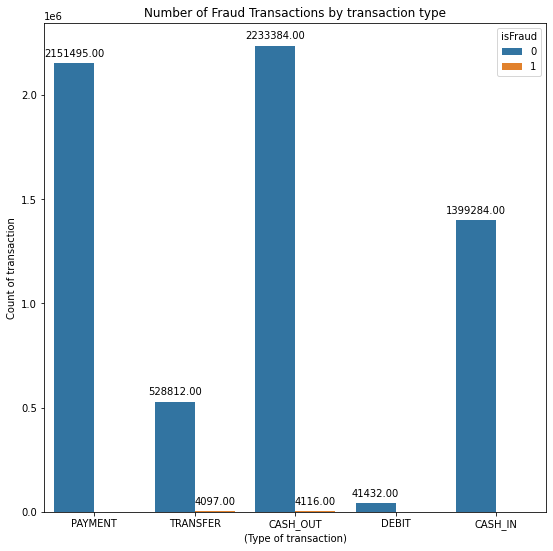

In [ ]:
plt.figure(figsize=(9,9))
fig = sns.countplot(df.type,hue='isFraud',data=df)
fig.set(title='Number of Fraud Transactions by transaction type')
fig.set_xlabel("(Type of transaction)")
fig.set_ylabel("Count of transaction")
for p in fig.patches:
  fig.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [8]:
df.groupby('isFraud')['type'].value_counts()

isFraud  type    
0        CASH_OUT    2233384
         PAYMENT     2151495
         CASH_IN     1399284
         TRANSFER     528812
         DEBIT         41432
1        CASH_OUT       4116
         TRANSFER       4097
Name: type, dtype: int64

In [11]:
df_isfraud = df[df.isFraud==1]

<AxesSubplot:>

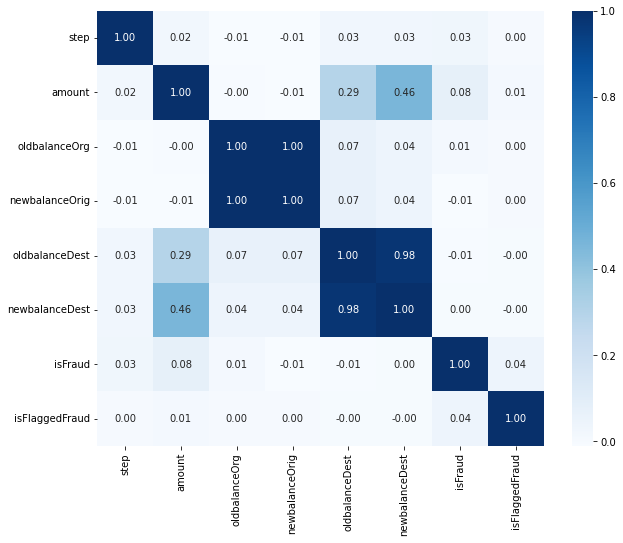

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),cmap="Blues",annot=True,fmt='.2f')

In [ ]:
# looking at above heatmap, we can tell that oldbalanceorg and newbalanceorig had a very high correlation, so does , oldbalancedest and newbalancedest, therefore, we can drop one of each. 

In [ ]:
# lets make a dataframe sample which isfraud is proportional to the oringal dataset, for easier training in early development.

In [5]:
df_samp = df.groupby('isFraud', group_keys=False).apply(lambda x: x.sample(frac=0.01))

In [35]:
df_samp.isFraud.value_counts()/len(df_samp)

0    0.99871
1    0.00129
Name: isFraud, dtype: float64

In [6]:
df_samp_reg =  pd.get_dummies(df_samp,columns=['type'],drop_first=True)
df_samp_reg.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
2203084,185,52514.86,C928160670,3096.0,0.00,C1267335682,4630712.97,4683227.83,0,0,1,0,0,0
2851009,227,73510.11,C276234176,11007.0,0.00,C1550362847,130874.66,204384.77,0,0,1,0,0,0
4026620,299,340409.01,C1891156005,131110.0,0.00,C1852600081,0.00,340409.01,0,0,1,0,0,0
6185605,567,139973.71,C1947911688,15566.0,0.00,C1144167165,0.00,139973.71,0,0,1,0,0,0
5180993,359,1418.24,C71215285,35778.0,34359.76,M956548890,0.00,0.00,0,0,0,0,1,0


In [8]:
df_samp_features = df_samp.drop(['type','nameOrig','nameDest','newbalanceOrig','oldbalanceDest','isFlaggedFraud'],axis=1)

In [9]:
df_samp_features.head()

,amount,oldbalanceOrg,newbalanceDest,isFraud
676033,14756.39,0.0,0.00,0
5533164,14354.94,5681.0,0.00,0
3844969,27359.05,0.0,1784364.15,0
6220241,66411.12,0.0,730975.10,0
5318798,92472.02,116.0,92472.02,0


In [10]:
scaler = RobustScaler()
df_samp_features_scaled = pd.DataFrame((scaler.fit_transform(df_samp_features)),columns=df_samp_features.columns)

In [11]:
df_samp_features_scaled.head()

,amount,oldbalanceOrg,newbalanceDest,isFraud
0,-0.306967,-0.136758,-0.195200,0.0
1,-0.309017,-0.084143,-0.195200,0.0
2,-0.242611,-0.136758,1.438475,0.0
3,-0.043190,-0.136758,0.474045,0.0
4,0.089891,-0.135684,-0.110537,0.0


In [12]:
a = np.array(df_samp_features_scaled)
y_samp_features_scaled = a[:,3] # classes having 0 and 1
y_samp_features_scaled = y_samp_features_scaled.astype('int')
x_samp_features_scaled = df_samp_features_scaled.drop('isFraud',axis=1)
x_array = np.array(x_samp_features_scaled)

In [13]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x_array, y_samp_features_scaled, test_size=0.3,random_state=109) # 70% training and 30% test


In [14]:
print(X_train)

[[-0.37702686 -0.13515604 -0.19519973]
 [-0.3577612  -0.13675831 -0.19519973]
 [-0.19982456 -0.13675831  3.57757708]
 ...
 [ 0.47127233 -0.13474852  1.28466607]
 [ 0.40853646  0.07379725 -0.05340697]
 [-0.25510823  8.28344267 -0.19519973]]


In [15]:
print((y_train))

[0 0 0 ... 0 0 0]


In [ ]:
C = 1.0
max_score = 0.0
for i in range(10) :
    print(i)
    start_time = time.time()
    clf_p = svm.SVC(kernel="poly", degree=i, gamma="auto", C=C)
    clf_p.fit(X_train, y_train)
    score = 100.0 * clf_p.score(X_test, y_test)
    y_pred_p = clf_p.predict(X_test)
    # Model Accuracy: how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred_p))

    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:",metrics.precision_score(y_test, y_pred_p))

    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:",metrics.recall_score(y_test, y_pred_p))

    # Model f1: the model score as a function of precision and recall score
    print("F1_score", metrics.f1_score(y_test, y_pred_p))

    # Model AUC : Area under precision recall
    print("AUC", metrics.average_precision_score(y_test, y_pred_p))
    print("/")
    if score > max_score:
        clf_best = clf_p
        max_score = score
        print(max_score)


0
Accuracy: 0.9986378876781223
Precision: 0.0
Recall: 0.0
F1_score 0.0
AUC 0.0013621123218776194
/
99.86378876781224
1


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9986378876781223
Precision: 0.0
Recall: 0.0
F1_score 0.0
AUC 0.0013621123218776194
/
2


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9991617770326907
Precision: 1.0
Recall: 0.38461538461538464
F1_score 0.5555555555555556
AUC 0.3854536075826939
/
99.91617770326907
3
Accuracy: 0.9992141659681475
Precision: 1.0
Recall: 0.4230769230769231
F1_score 0.5945945945945945
AUC 0.4238627571087755
/
99.92141659681475
4


In [43]:
C = 1.0  # SVM regularization parameter
clf_p = svm.SVC(kernel="poly", degree=3, gamma="auto", C=C)
clf_p.fit(X_train, y_train) 

y_pred_p = clf_p.predict(X_test)

In [44]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_p))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred_p))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred_p))

# Model f1: the model score as a function of precision and recall score
print("F1_score", metrics.f1_score(y_test, y_pred_p))

# Model AUC : Area under precision recall
print("AUC", metrics.average_precision_score(y_test, y_pred_p))

Accuracy: 0.9984284965950759
Precision: 0.0
Recall: 0.0
F1_score 0.0
AUC 0.001571503404924044


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
C = 1.0  # SVM regularization parameter
clf_r = svm.SVC(kernel="rbf", gamma="auto", C=C)
clf_r.fit(X_train, y_train) 

y_pred_r = clf_r.predict(X_test)

In [31]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_r))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred_r))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred_r))

# Model f1: the model score as a function of precision and recall score
print("F1_score", metrics.f1_score(y_test, y_pred_r))

Accuracy: 0.9994761655316919
Precision: 0.0
Recall: 0.0
F1_score 0.0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
C = 1.0  # SVM regularization parameter
clf_l = svm.LinearSVC(C=C, max_iter=10000)
clf_l.fit(X_train, y_train) 

y_pred_l = clf_l.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [33]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_l))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred_l))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred_l))

# Model f1: the model score as a function of precision and recall score
print("F1_score", metrics.f1_score(y_test, y_pred_l))

Accuracy: 0.9994761655316919
Precision: 0.0
Recall: 0.0
F1_score 0.0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
C = 1.0  # SVM regularization parameter
clf_l = svm.SVC(kernel="linear", C=C)
clf_l.fit(X_train, y_train) 

y_pred_l2 = clf_l.predict(X_test)

In [35]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_l2))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred_l2))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred_l2))

# Model f1: the model score as a function of precision and recall score
print("F1_score", metrics.f1_score(y_test, y_pred_l2))

# Model AUC : Area under precision recall
print("AUC", metrics.average_precision_score(y_test, y_pred_l2))

Accuracy: 0.9994761655316919
Precision: 0.0
Recall: 0.0
F1_score 0.0
AUC 0.0005238344683080147


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


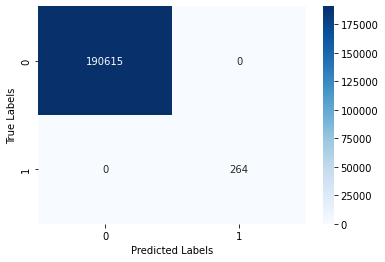

In [ ]:
cm = confusion_matrix(y_test, y_pred_p)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)

In [ ]:
# Muller loop

In [42]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "GaussianProcess",
"Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
"Naive Bayes", "QDA"]
classifiers = [ KNeighborsClassifier(2), SVC(kernel="linear", C=0.025),
SVC(gamma=2, C=1),
GaussianProcessClassifier(1.0 * RBF(1.0)),
DecisionTreeClassifier(max_depth=5),
RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
MLPClassifier(alpha=1, max_iter=1000),
AdaBoostClassifier(),
GaussianNB(),
QuadraticDiscriminantAnalysis()]

X, y = x_samp_features_scaled, y_samp_features_scaled
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

max_score = 0.0
max_class = ''
# iterate over classifiers
for name, clf in zip(names, classifiers):
  start_time = time.time()
  clf.fit(X_train, y_train)
  score = 100.0 * clf.score(X_test, y_test)
  print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time.time() - start_time))
  if score > max_score:
    clf_best = clf
    max_score = score
    print(max_score)
    max_class = name
print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f', (max_class, max_score))

Classifier = Nearest Neighbors, Score (test, accuracy) = 99.84, Training time = 0.10 seconds
99.84284965950759
Classifier = Linear SVM, Score (test, accuracy) = 99.84, Training time = 0.02 seconds
Classifier = RBF SVM, Score (test, accuracy) = 99.84, Training time = 0.04 seconds
Classifier = GaussianProcess, Score (test, accuracy) = 99.84, Training time = 477.64 seconds
Classifier = Decision Tree, Score (test, accuracy) = 99.74, Training time = 0.01 seconds
Classifier = Random Forest, Score (test, accuracy) = 99.84, Training time = 0.05 seconds
Classifier = Neural Net, Score (test, accuracy) = 99.84, Training time = 2.06 seconds
Classifier = AdaBoost, Score (test, accuracy) = 99.74, Training time = 0.25 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 77.16, Training time = 0.00 seconds
Classifier = QDA, Score (test, accuracy) = 0.16, Training time = 0.04 seconds
--------------------------------------------------------------------------------
Best --> Classifier = %s, Score (

/usr/local/lib/python3.8/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.8/dist-packages/sklearn/discriminant_analysis.py:903: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.8/dist-packages/sklearn/discriminant_analysis.py:903: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.8/dist-packages/sklearn/discriminant_analysis.py:906: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(x_array, y_samp_features_scaled)

In [ ]:
# split the data into training and testing sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)

# train an SVM classifier on the oversampled data
C = 1.0  # SVM regularization parameter
clf_p_s = svm.SVC(kernel="poly", degree=3, gamma="auto", C=C)
clf_p_s.fit(X_train_smote, y_train_smote)

# make predictions on the test set
y_pred_p_s = clf_p_s.predict(X_test_smote)


In [28]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_smote, y_pred_p_s))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test_smote, y_pred_p_s))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test_smote, y_pred_p_s))

# Model f1: the model score as a function of precision and recall score
print("F1_score", metrics.f1_score(y_test_smote, y_pred_p_s))

# Model AUC : Area under precision recall
print("AUC", metrics.average_precision_score(y_test_smote, y_pred_p_s))

Accuracy: 0.7288224495148178
Precision: 0.6446735395189004
Recall: 1.0
F1_score 0.7839531968240703
AUC 0.6446735395189004
